In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from ray import tune #for hyper parameter tuning
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('processed_data.csv')
data.head(3)

,Year,Month,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Berri1,Maisonneuve_2,Maisonneuve_1
0,2009.0,1.0,1.0,-14.7,-19.9,-17.3,-23.125000,59.916667,28.291667,17.375000,29.0,35.0,20.0
1,2009.0,1.0,2.0,-11.3,-16.2,-13.8,-17.029167,76.250000,7.083333,12.250000,19.0,22.0,3.0
2,2009.0,1.0,3.0,-8.1,-13.0,-10.6,-15.441667,67.958333,28.208333,22.541667,24.0,22.0,12.0


In [3]:
X = torch.Tensor(data.drop(columns=['Berri1','Maisonneuve_2','Maisonneuve_1']).to_numpy())
X = X[:, 3:]

y = torch.Tensor(data['Berri1'].to_numpy()).unsqueeze(1)

create custom bin sizes based on Freedman–Diaconis rule see: https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule

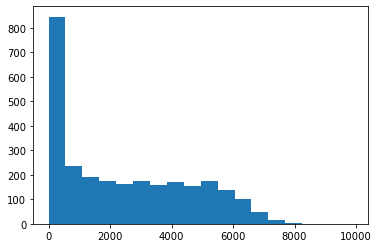

In [4]:
q3, q1 = np.percentile(y,[75,25])
bin_width = 2*(q3-q1)/np.cbrt(len(y))

bins = np.arange(0,10_000,bin_width)
plt.hist(y.squeeze().numpy(), bins=bins);

Create classes for each bin and one-hot encode the labels

In [5]:
y_bin = np.digitize(y, bins)
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder()
y_hot = torch.Tensor((one_hot.fit_transform(y_bin)).toarray())
y_hot[0:4]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Let's Split the test, train and validation datasets

In [6]:
X_train,X_test, y_train, y_test = train_test_split(X,y_hot, test_size=0.15)

X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size=0.3)

print("X:", X.shape, "y:", y.shape,
      "\nX_train:", X_train.shape, "y_train:", y_train.shape,
      "\nX_test:", X_test.shape, "y_test:", y_test.shape,
     "\nX_val:", X_val.shape, "y_val:", y_val.shape)


X: torch.Size([2743, 7]) y: torch.Size([2743, 1]) 
X_train: torch.Size([2331, 7]) y_train: torch.Size([2331, 16]) 
X_test: torch.Size([288, 7]) y_test: torch.Size([288, 16]) 
X_val: torch.Size([124, 7]) y_val: torch.Size([124, 16])


For this first model we will simply feed the data and solve a regression task.

In [7]:
class BikeModel(torch.nn.Module):
    def __init__(self,batch_first=True, linear=10, drop=0.50):
        super(BikeModel, self).__init__()
        self.linear1 = torch.nn.Linear(in_features=7, out_features=linear)
        self.linear2 = torch.nn.Linear(in_features=linear,out_features=linear)
        self.linear3 = torch.nn.Linear(in_features=linear,out_features=16)
        self.drop1 = torch.nn.Dropout(p=drop)
        self.drop2 = torch.nn.Dropout(p=drop)
    def forward(self, X):
        H = self.linear1(X)
        H = self.drop1(torch.nn.functional.relu(H))
        Z = self.linear2(H)
        Z = self.drop2(torch.nn.functional.relu(Z))
        Z = self.linear3(Z)
        return Z

In [8]:
#def train(config):
# Initialize the model 

ann = BikeModel(linear=60, drop=0.5)
#ann = BikeModel(linear=config['linear'], drop=config['drop'])

batch_size= 1024#config['batch']
num_epoch = 2000#config['epoch']

# Initialize the Loss. 
loss = torch.nn.CrossEntropyLoss()
train_loss = []
test_loss = []
# Initialize the Optimizer.
optimizer = torch.optim.AdamW(ann.parameters(), lr=0.005)#config['lr'])

for epoch in range(num_epoch):
    ann.train() #set model to training mode
    for i in range(0, X_train.shape[0], batch_size):

        # Read minibatches (for both X and y)
        Xi = X_train[i:i+batch_size]
        yi = y_train[i:i+batch_size]

        # Run the RNN model
        output = ann.forward(Xi)

        l = loss(output,yi)

        # Update the parameters
        ann.zero_grad()
        l.backward()
        optimizer.step()

    train_loss.append(l.item())
    ann.eval()
    output = ann.forward(X_test)
    l_test = torch.nn.functional.cross_entropy(output, y_test)
    test_loss.append(l_test.item())
#         tune.report(l_val.item())
    #Print loss
    if (epoch + 1) % 50 == 0:
        print("Epoch %03d: Train_loss: %.4f " %(epoch+1, l.item()))
        print("Epoch %03d: Test_loss: %.4f " %(epoch+1, l_test))

# config = {"lr":tune.grid_search([0.001, 0.002, 0.005, 0.01]),
#           "batch":tune.grid_search([1024,2048]),
#          "linear":tune.grid_search([40,60,80,100]),
#         "epoch":tune.grid_search([2000,3000]),
#          "drop":tune.grid_search([0.3,0.4,0.5])}

# analysis = tune.run(train, config=config)
# df = analysis.dataframe()
# df.to_csv('hyper_param_search.csv', index=False)


Epoch 050: Train_loss: 1.5477 
Epoch 050: Test_loss: 1.7284 
Epoch 100: Train_loss: 1.5146 
Epoch 100: Test_loss: 1.7128 
Epoch 150: Train_loss: 1.4307 
Epoch 150: Test_loss: 1.6793 
Epoch 200: Train_loss: 1.4457 
Epoch 200: Test_loss: 1.6774 
Epoch 250: Train_loss: 1.4193 
Epoch 250: Test_loss: 1.6702 
Epoch 300: Train_loss: 1.4508 
Epoch 300: Test_loss: 1.6699 
Epoch 350: Train_loss: 1.4017 
Epoch 350: Test_loss: 1.6647 
Epoch 400: Train_loss: 1.4024 
Epoch 400: Test_loss: 1.6622 
Epoch 450: Train_loss: 1.4054 
Epoch 450: Test_loss: 1.6804 
Epoch 500: Train_loss: 1.3540 
Epoch 500: Test_loss: 1.6716 
Epoch 550: Train_loss: 1.3796 
Epoch 550: Test_loss: 1.6571 
Epoch 600: Train_loss: 1.3901 
Epoch 600: Test_loss: 1.6800 
Epoch 650: Train_loss: 1.4027 
Epoch 650: Test_loss: 1.6740 
Epoch 700: Train_loss: 1.3598 
Epoch 700: Test_loss: 1.6620 
Epoch 750: Train_loss: 1.3881 
Epoch 750: Test_loss: 1.6671 
Epoch 800: Train_loss: 1.3850 
Epoch 800: Test_loss: 1.6651 
Epoch 850: Train_loss: 1

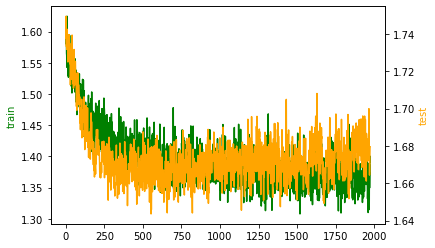

In [9]:
ax = plt.subplot((111))
plt.plot(train_loss[25:], 'green')
plt.ylabel('train', c='green')
ax2= ax.twinx()
plt.plot(test_loss[25:], 'orange')
plt.ylabel('test', c='orange');

Train Data performance

C:\Users\samue\AppData\Local\Temp/ipykernel_7496/3777691127.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  vx_train, ix_train = torch.max(torch.nn.functional.softmax(ann.forward(X_train).detach()) , 1)


(tensor([ 6,  0,  2,  0,  1, 10,  0,  0, 10,  6]),
 tensor([6, 0, 3, 0, 1, 9, 0, 0, 8, 4]))

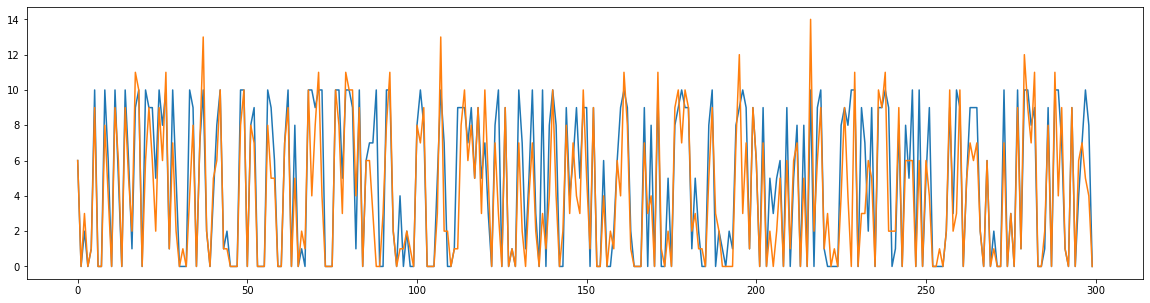

In [10]:
#from sklearn.metrics import accuracy_score
ann.eval()
vx_train, ix_train = torch.max(torch.nn.functional.softmax(ann.forward(X_train).detach()) , 1)
vy_train, iy_train = torch.max(y_train, 1)
plt.figure(figsize=(20,5))
plt.plot(ix_train[0:300])
plt.plot(iy_train[0:300])
ix_train[0:10], iy_train[0:10]

Test data performance

C:\Users\samue\AppData\Local\Temp/ipykernel_7496/2691291243.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  vx_test, ix_test = torch.max(torch.nn.functional.softmax(ann.forward(X_test).detach()), 1)


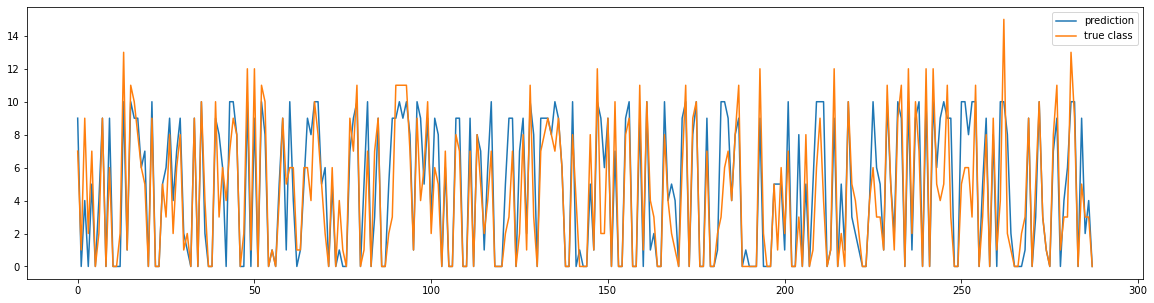

In [11]:
vx_test, ix_test = torch.max(torch.nn.functional.softmax(ann.forward(X_test).detach()), 1)
vy_test, iy_test = torch.max(y_test, 1)
plt.figure(figsize=(20,5))
plt.plot(ix_test)
plt.plot(iy_test);
plt.legend(['prediction', 'true class'])

In [12]:
from sklearn.metrics import accuracy_score

print("Training accuracy: {:.2f}%".format( accuracy_score(ix_train,iy_train)*100) )
print("Testing accuracy: {:.2f}%".format( accuracy_score(ix_test,iy_test)*100) )

Training accuracy: 44.70%
Testing accuracy: 39.58%
